Kaggle データセットの分析  
https://www.kaggle.com/neuromusic/avocado-prices

アメリカのハスアボカドというアボカドの品種に関する小売データセット。  
各都市の一週間ごとデータが記録されている。

- 日付 2015-01-04 ～ 2018-03-25
- アボカド1個あたり平均価格
- 消費量？
- PLU codes 生鮮食品を販売管理するためのコード。4046はアボカドサイズ（小）、4225は中、4770は大を意味する。
- TotalBags small+large+xlarge bags
- type 従来型か有機栽培か
- 都市

分析案  
- ~~時系列的な特徴がないとして分析~~
- 層別（regeonごと）の平均価格の平均、総量の平均をみる
- 系列の周期性があるか確認
- 周期性あり→層別にモデルを作るのではなく、層の情報を生かしたモデルを調査
- 周期性なし→再検討

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from tslearn.clustering import KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

In [2]:
# ファイル読み込み
in_file = '../data/avocado.csv'
df = pd.read_csv(in_file, header=0, index_col=0)

# 日付を文字列から日付型に変換
df['Date'] = pd.to_datetime(df['Date'])
df['type'] = pd.Series(np.where(df.type=='conventional', 1, 0), name='type')
df.sort_values(['Date', 'region'])
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,1,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,1,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,1,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,1,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,1,2015,Albany


In [3]:
# テーブルサイズ確認
df.shape

(18249, 13)

In [4]:
# データの基本統計量確認
df.describe()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year
count,18249.000000,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,18249.000000,18249.0,18249.000000
mean,1.405978,8.506440e+05,2.930084e+05,2.951546e+05,2.283974e+04,2.396392e+05,1.821947e+05,5.433809e+04,3106.426507,1.0,2016.147899
std,0.402677,3.453545e+06,1.264989e+06,1.204120e+06,1.074641e+05,9.862424e+05,7.461785e+05,2.439660e+05,17692.894652,0.0,0.939938
min,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.0,2015.000000
25%,1.100000,1.083858e+04,8.540700e+02,3.008780e+03,0.000000e+00,5.088640e+03,2.849420e+03,1.274700e+02,0.000000,1.0,2015.000000
50%,1.370000,1.073768e+05,8.645300e+03,2.906102e+04,1.849900e+02,3.974383e+04,2.636282e+04,2.647710e+03,0.000000,1.0,2016.000000
75%,1.660000,4.329623e+05,1.110202e+05,1.502069e+05,6.243420e+03,1.107834e+05,8.333767e+04,2.202925e+04,132.500000,1.0,2017.000000
max,3.250000,6.250565e+07,2.274362e+07,2.047057e+07,2.546439e+06,1.937313e+07,1.338459e+07,5.719097e+06,551693.650000,1.0,2018.000000


In [5]:
# regionラベル54個の一覧表示
for reg in set(df.region): print(reg, end=' ')

SanFrancisco Columbus NorthernNewEngland Philadelphia Atlanta Southeast SouthCarolina Spokane Pittsburgh Sacramento Louisville Tampa Midsouth Northeast HartfordSpringfield Charlotte RichmondNorfolk Plains Syracuse West Albany RaleighGreensboro SanDiego GrandRapids Boise California Portland Detroit PhoenixTucson LosAngeles StLouis CincinnatiDayton NewOrleansMobile DallasFtWorth Orlando BaltimoreWashington BuffaloRochester Nashville GreatLakes Houston HarrisburgScranton Roanoke TotalUS WestTexNewMexico Chicago Boston Indianapolis LasVegas NewYork Seattle MiamiFtLauderdale Jacksonville Denver SouthCentral 

In [6]:
# regionごとに平均値出力
df_groupby = df.groupby("region",as_index=False)
df_groupby.mean().head()

,region,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year
0,Albany,1.561036,47537.869734,1824.081775,37621.208254,162.832337,7929.747367,6647.765473,1153.496213,128.488639,1,2016.147929
1,Atlanta,1.337959,262145.322041,146116.867959,31218.510385,311.385769,84498.560888,51605.727337,32070.044556,822.786036,1,2016.147929
2,BaltimoreWashington,1.534231,398561.891479,35656.218166,245982.888876,12466.730976,104456.053462,100939.683195,2903.984586,612.382722,1,2016.147929
3,Boise,1.348136,42642.567308,20019.507604,3461.682367,3186.787840,15974.592456,13840.037249,2103.634083,30.915207,1,2016.147929
4,Boston,1.530888,287792.854527,4994.610059,214219.864290,4982.294970,63596.085207,58906.590355,4438.364704,251.124231,1,2016.147929


In [7]:
# regionごと平均の基本統計量
df_groupby.mean().describe()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year
count,54.000000,5.400000e+01,5.400000e+01,5.400000e+01,54.000000,5.400000e+01,5.400000e+01,5.400000e+01,54.000000,54.0,54.000000
mean,1.405955,8.505751e+05,2.930015e+05,2.951169e+05,22837.438880,2.396171e+05,1.821745e+05,5.433654e+04,3106.069740,1.0,2016.147898
std,0.166653,2.419120e+06,8.683353e+05,8.363299e+05,66626.358138,6.768062e+05,5.138323e+05,1.607019e+05,9179.465604,0.0,0.000226
min,1.047929,3.237476e+04,9.816233e+02,3.461682e+03,78.368846,7.929747e+03,6.647765e+03,2.269676e+02,21.250651,1.0,2016.146269
25%,1.287848,1.052357e+05,2.052716e+04,3.167778e+04,834.040740,3.481852e+04,2.645064e+04,3.273603e+03,258.645022,1.0,2016.147929
50%,1.400725,2.120883e+05,5.705663e+04,6.370831e+04,4783.209911,5.569507e+04,4.129541e+04,1.216920e+04,639.571169,1.0,2016.147929
75%,1.515947,5.419719e+05,1.677572e+05,2.380421e+05,11830.519808,1.480396e+05,1.158157e+05,3.462434e+04,1239.461501,1.0,2016.147929
max,1.818639,1.735130e+07,6.079693e+06,5.961573e+06,462056.754822,4.847931e+06,3.679175e+06,1.105279e+06,63477.013432,1.0,2016.147929


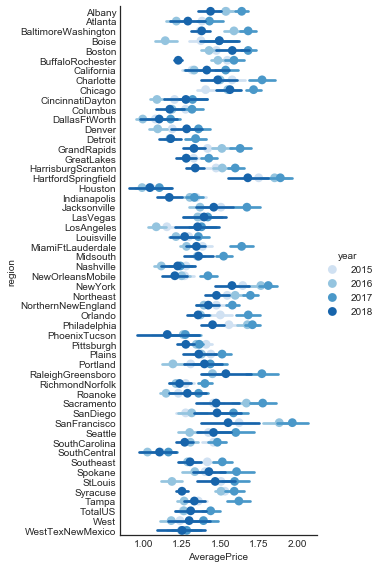

In [8]:
# seabornで可視化
# これで都市ごと年毎に平均価格が異なるということがわかる
# カーネル通りに実行
# https://www.kaggle.com/neuromusic/avocado-prices-across-regions-and-seasons
import seaborn as sns
sns.set_style('white')

mask = df['type']==1
g = sns.factorplot('AveragePrice','region',data=df[mask],
                   hue='year',
                   size=8,
                   aspect=0.6,
                   palette='Blues',
                   join=False,
              )

In [9]:
order = (
    df[mask & (df['year']==2018)]
    .groupby('region')['AveragePrice']
    .mean()
    .sort_values()
    .index
)

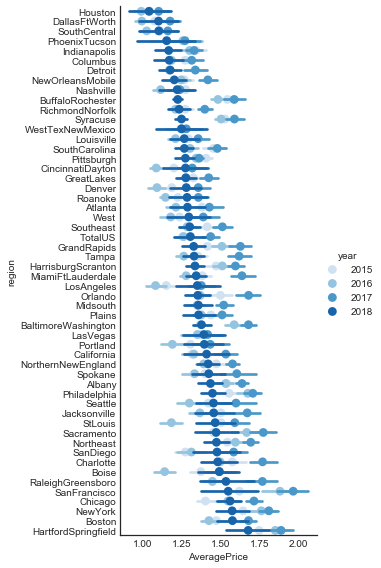

In [10]:
# ソートして最後プロット
# アメリカ南部ほど安く、北部ほど高い傾向
# これもカーネル通り実行
# https://www.kaggle.com/neuromusic/avocado-prices-across-regions-and-seasons
g = sns.factorplot('AveragePrice','region',data=df[mask],
                   hue='year',
                   size=8,
                   aspect=0.6,
                   palette='Blues',
                   order=order,
                   join=False,
              )

In [11]:
# 都市をダミー変数に変換して結合
cities = pd.get_dummies(df.region, prefix='City')
df_dummy = pd.concat([df, cities], axis=1)

In [12]:
# 予測用データセット作成
y = {'average price': df_dummy['AveragePrice']}
del df_dummy['AveragePrice']
del df_dummy['Date']
del df_dummy['region']
del df_dummy['4046']
del df_dummy['4225']
del df_dummy['4770']

In [13]:
# 学習データとテストデータ作成
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_dummy, pd.DataFrame(y))

In [14]:
# モデル作成
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
lars = linear_model.Lars()
lars_cv = linear_model.LarsCV()
lasso = linear_model.Lasso()
lasso_cv = linear_model.LassoCV()
lasso_lars = linear_model.LassoLars()
lasso_lars_cv = linear_model.LassoLarsCV()
lasso_lars_aic = linear_model.LassoLarsIC(criterion='aic')
lasso_lars_bic = linear_model.LassoLarsIC(criterion='bic')
linear_reg = linear_model.LinearRegression()
knn_1 = KNeighborsRegressor(n_neighbors=1)
knn_3 = KNeighborsRegressor(n_neighbors=3)
knn_5 = KNeighborsRegressor(n_neighbors=5)
knn_7 = KNeighborsRegressor(n_neighbors=7)
knn_9 = KNeighborsRegressor(n_neighbors=9)
knn_11 = KNeighborsRegressor(n_neighbors=11)
knn_13 = KNeighborsRegressor(n_neighbors=13)
knn_15 = KNeighborsRegressor(n_neighbors=15)

In [15]:
def run(model, lab):
    model.fit(x_train, y_train.values.ravel())
    y_pred = model.predict(x_test)
    ac_mse = mean_squared_error(y_test, y_pred)
    ac_r2 = r2_score(y_test, y_pred)
    print('{:12}\tMSE: {:.4f}\tR2: {:.4f}'.format(lab, ac_mse, ac_r2))

In [16]:
# 精度確認
run(lars, 'lars')
run(lars_cv, 'lars_cv')
run(lasso, 'lasso')
run(lasso_cv, 'lasso_cv')
run(lasso_lars, 'lasso_lars')
run(lasso_lars_cv, 'lasso_lars_cv')
run(lasso_lars_aic, 'lasso_lars_aic')
run(lasso_lars_bic, 'lasso_lars_bic')
run(linear_reg, 'linear_reg')
run(knn_1, 'knn_1')
run(knn_3, 'knn_3')
run(knn_5, 'knn_5')
run(knn_7, 'knn_7')
run(knn_9, 'knn_9')
run(knn_11, 'knn_11')
run(knn_13, 'knn_13')
run(knn_15, 'knn_15')

lars        	MSE: 0.1261	R2: 0.2296
lars_cv     	MSE: 0.1262	R2: 0.2291
lasso       	MSE: 0.1577	R2: 0.0366
lasso_cv    	MSE: 0.1578	R2: 0.0362
lasso_lars  	MSE: 0.1637	R2: -0.0000
lasso_lars_cv	MSE: 0.1262	R2: 0.2291
lasso_lars_aic	MSE: 0.1261	R2: 0.2296
lasso_lars_bic	MSE: 0.1265	R2: 0.2271
linear_reg  	MSE: 0.1291	R2: 0.2114
knn_1       	MSE: 0.1274	R2: 0.2218
knn_3       	MSE: 0.0867	R2: 0.4704
knn_5       	MSE: 0.0805	R2: 0.5084
knn_7       	MSE: 0.0773	R2: 0.5282
knn_9       	MSE: 0.0769	R2: 0.5306
knn_11      	MSE: 0.0765	R2: 0.5327
knn_13      	MSE: 0.0762	R2: 0.5348
knn_15      	MSE: 0.0759	R2: 0.5364


系列データを分析するライブラリ tslearn の練習。

- region ごとの AveragePrice を可視化。
- エルボー法によるクラスター数確認。
- クラスタリング。

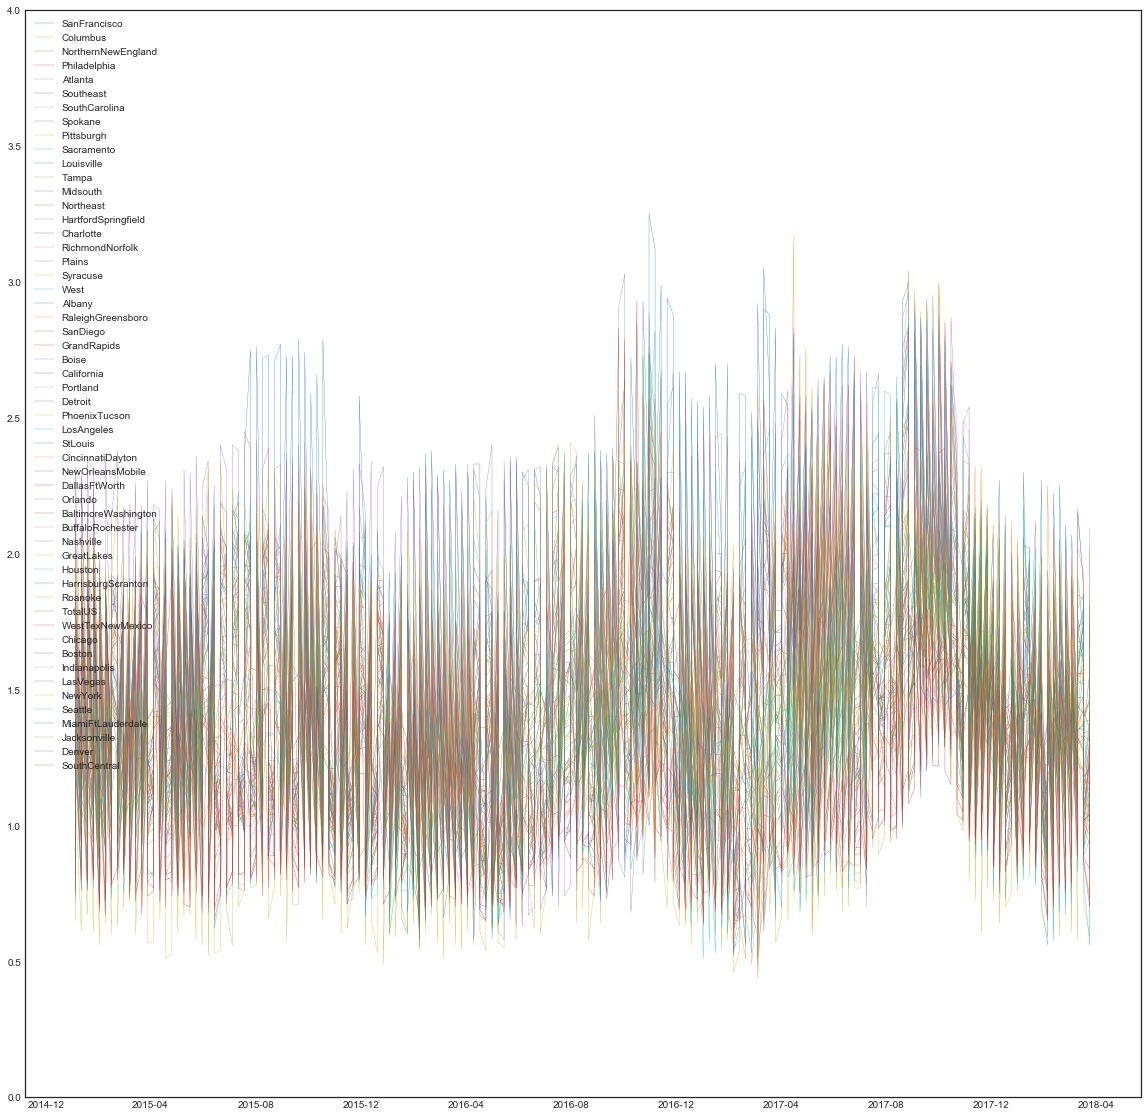

In [17]:
# 地域ごとの平均価格の系列を確認
plt.figure(figsize=(20, 20))
plt.ylim([0,4])
for region_name in set(df.region):
    df_ = df[df.region==region_name]
    df_ = df_.sort_values('Date')
    plt.plot(df_.Date, df_.AveragePrice, label=region_name, lw=.3, alpha=1)
plt.legend()
plt.show()

In [18]:
stack_data = []
regions = list(set(df.region))
regions.sort()
for region_name in regions:
    df_ = df[df.region==region_name]
    df_ = df_.sort_values('Date')
    stack_data.append(df_.AveragePrice.ravel().tolist())
    # print(df_.AveragePrice.shape)
len_max = max([len(ts) for ts in stack_data])
for i, ts in enumerate(stack_data):
    len_add = len_max - len(ts)
    stack_data[i] = ts + [ts[-1]] * len_add
stack_data = np.stack(stack_data, axis=0)

Init 1
0.432 --> 0.265 --> 0.266 --> 
Init 2
0.319 --> 0.213 --> 0.211 --> 0.209 --> 0.208 --> 0.207 --> 0.207 --> 0.207 --> 0.207 --> 0.206 --> 0.206 --> 0.206 --> 0.205 --> 0.205 --> 0.205 --> 0.205 --> 0.204 --> 0.203 --> 0.203 --> 0.205 --> 
Init 3
0.349 --> 0.216 --> 0.214 --> 0.216 --> 
Init 4
0.316 --> 0.238 --> 0.239 --> 
Init 5
0.281 --> 0.266 --> 0.268 --> 
Init 6
0.307 --> 0.239 --> 0.239 --> 0.240 --> 
Init 7
0.386 --> 0.359 --> 0.241 --> 0.219 --> 0.219 --> 
Init 8
0.272 --> 0.262 --> 0.264 --> 
Init 9
0.299 --> 0.291 --> 0.291 --> 0.289 --> 0.288 --> 0.286 --> 0.285 --> 0.285 --> 0.282 --> 0.282 --> 0.279 --> 0.279 --> 0.277 --> 0.276 --> 0.276 --> 
Init 10
0.258 --> 0.235 --> 0.236 --> 
Init 1
0.279 --> 0.185 --> 0.181 --> 0.181 --> 0.180 --> 0.180 --> 0.180 --> 
Init 2
0.228 --> 0.196 --> 0.191 --> 0.187 --> 0.186 --> 0.186 --> 0.185 --> 0.185 --> 0.185 --> 0.185 --> 0.184 --> 0.184 --> 0.183 --> 0.183 --> 0.182 --> 0.181 --> 0.181 --> 0.180 --> 0.180 --> 0.179 --> 0.17

Resumed because of empty cluster
Init 2
Resumed because of empty cluster
Init 2
Resumed because of empty cluster
Init 1
Resumed because of empty cluster
Init 1
Resumed because of empty cluster
Init 1
Resumed because of empty cluster
Init 1
Resumed because of empty cluster
Init 1
Resumed because of empty cluster
Init 1
Resumed because of empty cluster
Init 1
Resumed because of empty cluster
Init 1
Resumed because of empty cluster
Init 1
Resumed because of empty cluster
Init 1
Resumed because of empty cluster
Init 1
Resumed because of empty cluster
Init 1
Resumed because of empty cluster
Init 1
Resumed because of empty cluster
Init 1
Resumed because of empty cluster
Init 1
Resumed because of empty cluster
Init 1
Resumed because of empty cluster
Init 1
Resumed because of empty cluster
Init 1
Resumed because of empty cluster
Init 1
Resumed because of empty cluster
Init 1
Resumed because of empty cluster
Init 1
Resumed because of empty cluster
Init 1
Resumed because of empty cluster
Init 1


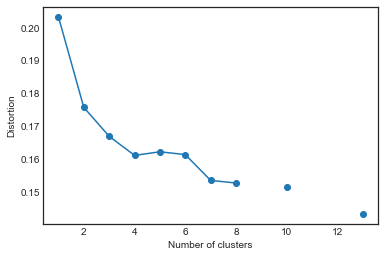

In [19]:
# クラスターの数をいくつに設定するか
distortions = []
seed = 0

#1~20クラスタまで計算 
for i in range(1,21):
    ks = KShape(n_clusters=i, n_init=10, verbose=True, random_state=seed)
    #クラスタリングの計算を実行
    tmp = ks.fit(stack_data)
    #ks.fitするとks.inertia_が得られる
    #inertia_でSSEを取得できる
    distortions.append(ks.inertia_)

plt.plot(range(1,21), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [20]:
seed = 1
np.random.seed(seed)
#相互相関を計算するために、データを正規化
stack_data = TimeSeriesScalerMeanVariance(mu=0.0, std=1.0).fit_transform(stack_data)

#KShapeクラス
ks = KShape(n_clusters=7, n_init=10, verbose=True, random_state=seed)
y_pred = ks.fit_predict(stack_data)

Init 1
Resumed because of empty cluster
Init 1
Resumed because of empty cluster
Init 1
Resumed because of empty cluster
Init 1
Resumed because of empty cluster
Init 1
Resumed because of empty cluster
Init 1
Resumed because of empty cluster
Init 1
Resumed because of empty cluster
Init 1
0.050 --> 0.022 --> 0.019 --> 0.019 --> 0.018 --> 0.017 --> 0.018 --> 
Init 2
Resumed because of empty cluster
Init 2
Resumed because of empty cluster


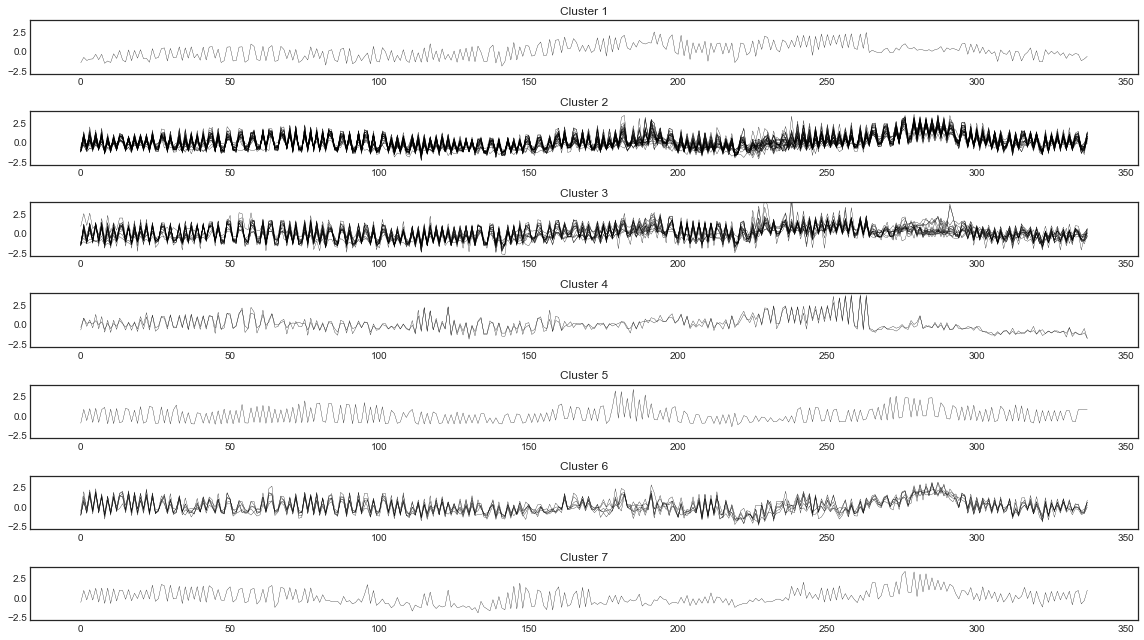

In [21]:
# クラスタリングして可視化
# 傾向を確認するのはよいが、かなり初期 seed 依存で、これをもとに考察しずらい
plt.figure(figsize=(16,9))
for yi in range(7):
    plt.subplot(7, 1, 1 + yi)
    for xx in stack_data[y_pred == yi]:
        plt.ylim([-3,4])
        plt.plot(xx.ravel(), "k-", lw=.3, alpha=1)
    #plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
    plt.title("Cluster %d" % (yi + 1))

plt.tight_layout()
plt.show()

In [22]:
for i, j in zip(regions, y_pred):
    if j==3: print(i, j)

BuffaloRochester 3
Syracuse 3
